# Finding datasets that have stopped being updated
This notebook shows how to find datasets that have stopped being updated.
It looks across all datasets and finds the datasets that have been stopped and then 
does analysis with the table types to show which have the highest percentage of being stopped.
This can be extended to find for departments that have stopped releasing certain types of data, what other types are they still releasing.

In [1]:
import openpolicedata as opd
from openpolicedata.exceptions import OPD_DataUnavailableError
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
# This cell filters out datasets that are not of interest to the analysis

# For the analysis we will exclude the openpolicing.stanford.edu and muckrock to prevent duplicates
all_datasets = opd.datasets.query()

# get the total number of datasets
starting_all_datasets_count=all_datasets.shape[0]

all_datasets['source_url'] = all_datasets['source_url'].astype(str)
all_datasets = all_datasets[~all_datasets['source_url'].str.contains("openpolicing.stanford.edu")]
all_datasets = all_datasets[~all_datasets['source_url'].str.contains("www.muckrock.com")]

print(f"Excluded {starting_all_datasets_count - all_datasets.shape[0]} datasets")

# focus on the main type for example change
# "USE OF FORCE - INCIDENTS"
# "USE OF FORCE - SUBJECTS/OFFICERS"
# to just "USE OF FORCE"
all_datasets['TableType'] = all_datasets['TableType'].str.split(' - ').str[0]

Excluded 82 datasets


In [24]:
# Now we will organize the data to make it easier to analyze
# Since we are interested in types datasets that have been stopped we want to focus on coverage start and end dates and the types
selected_columns = ['State', 'SourceName', 'TableType', 'coverage_start', 'coverage_end']
df = pd.DataFrame(all_datasets, columns=selected_columns)

# Drop rows with NaN values in 'coverage_start' and 'coverage_end' should be YEAR NONE
df = df.dropna(subset=['coverage_start', 'coverage_end'])
record_count_without_coverage_start_end = len(original_df) - len(df)

# Print the number of records dropped
print(f"Number of records dropped with N/A in either coverage_start or coverage_end: {record_count_without_coverage_start_end}")

# Create entries for each year instead of a range of years. This will create more data in a row, but will make it easier to filter the data
df['ListOfYears'] = df.apply(
    lambda row: list(range(int(row['coverage_start'].year), int(row['coverage_end'].year) + 1)), axis=1)

# no need for the coverage_start and coverage_end columns since we have the list of years
df = df.drop(columns=['coverage_start', 'coverage_end'])

# find any columns of 'ListOfYears' that are not list objects and print those rows
non_list_years = df[~df['ListOfYears'].apply(lambda x: isinstance(x, list))]

if len(non_list_years) > 0:
    print(f"Error, the ListOfYears column has {len(non_list_years)} values that are not lists are:")
    print(non_list_years)
else:
    pass # do nothing this is just a quality check, everything should be a list

Number of records dropped with N/A in either coverage_start or coverage_end: 20


In [25]:
# Focus on organizing up the ListOfYears column
# Finally check for duplicate values which should be zero

# merge rows that have the same values by extending the 'ListOfYears' column values into a single list
# Specifically this will merge table types that had " - " such as "USE OF FORCE - INCIDENTS" and "USE OF FORCE - SUBJECTS/OFFICERS"
df = df.groupby(['State', 'SourceName', 'TableType']).agg({'ListOfYears': 'sum'}).reset_index()
# remove any duplicate years from the 'ListOfYears' column and sort the list
df['ListOfYears'] = df['ListOfYears'].apply(lambda x: sorted(list(set(x))))

duplicates = df[df.duplicated(['State', 'SourceName', 'TableType'], keep=False)]
if len(duplicates) > 0:
    print(f"Error, the dataset has {len(duplicates)} duplicate rows. They are:")
    print(duplicates)
else:
    pass # do nothing since just another quality check

# count all the unique 'State', 'SourceName', and 'TableType' combinations 
unique_combinations = df.groupby(['State', 'SourceName', 'TableType']).size().reset_index(name='Count')

if len(unique_combinations) != len(df):
    print(f"Error, the dataset has {len(df) - len(unique_combinations)} duplicate rows. They are:")
    print(df[df.duplicated(['State', 'SourceName', 'TableType'], keep=False)])
else:
    pass # do nothing since just another quality check

# verify all the # ListOfYears are lists
non_list_years = df[~df['ListOfYears'].apply(lambda x: isinstance(x, list))]
if len(non_list_years) > 0:
    print(f"Error, the ListOfYears column has {len(non_list_years)} values that are not lists are:")
    print(non_list_years)
else:
    pass # do nothing this is just a quality check, everything should be a list

# Calculate the minimum and maximum years from the combined lists to simiplify the plotting
df['MinYear'] = df['ListOfYears'].apply(min)
df['MaxYear'] = df['ListOfYears'].apply(max)

# Create a label for plotting
df['Label'] = df['SourceName'] + ', ' + df['State'] + ', ' + df['TableType']

# find any rows where the MinYear is greater than the MaxYear or the MinYear is less than 2000 or either the MinYear or MaxYear are not integers
min_valid_year = 1960
invalid_years = df[(df['MinYear'] > df['MaxYear']) | (df['MinYear'] < min_valid_year) | (df['MinYear'] % 1 != 0) | (df['MaxYear'] % 1 != 0)]

if len(invalid_years) > 0:
    print(f"Error, the dataset has {len(invalid_years)} rows with invalid years. They are:")
    print(invalid_years)
else:
    pass # do nothing this is just a quality check, everything should be a list

print("If nothing else was printed that means the data is clean and ready for analysis")


If nothing else was printed that means the data is clean and ready for analysis


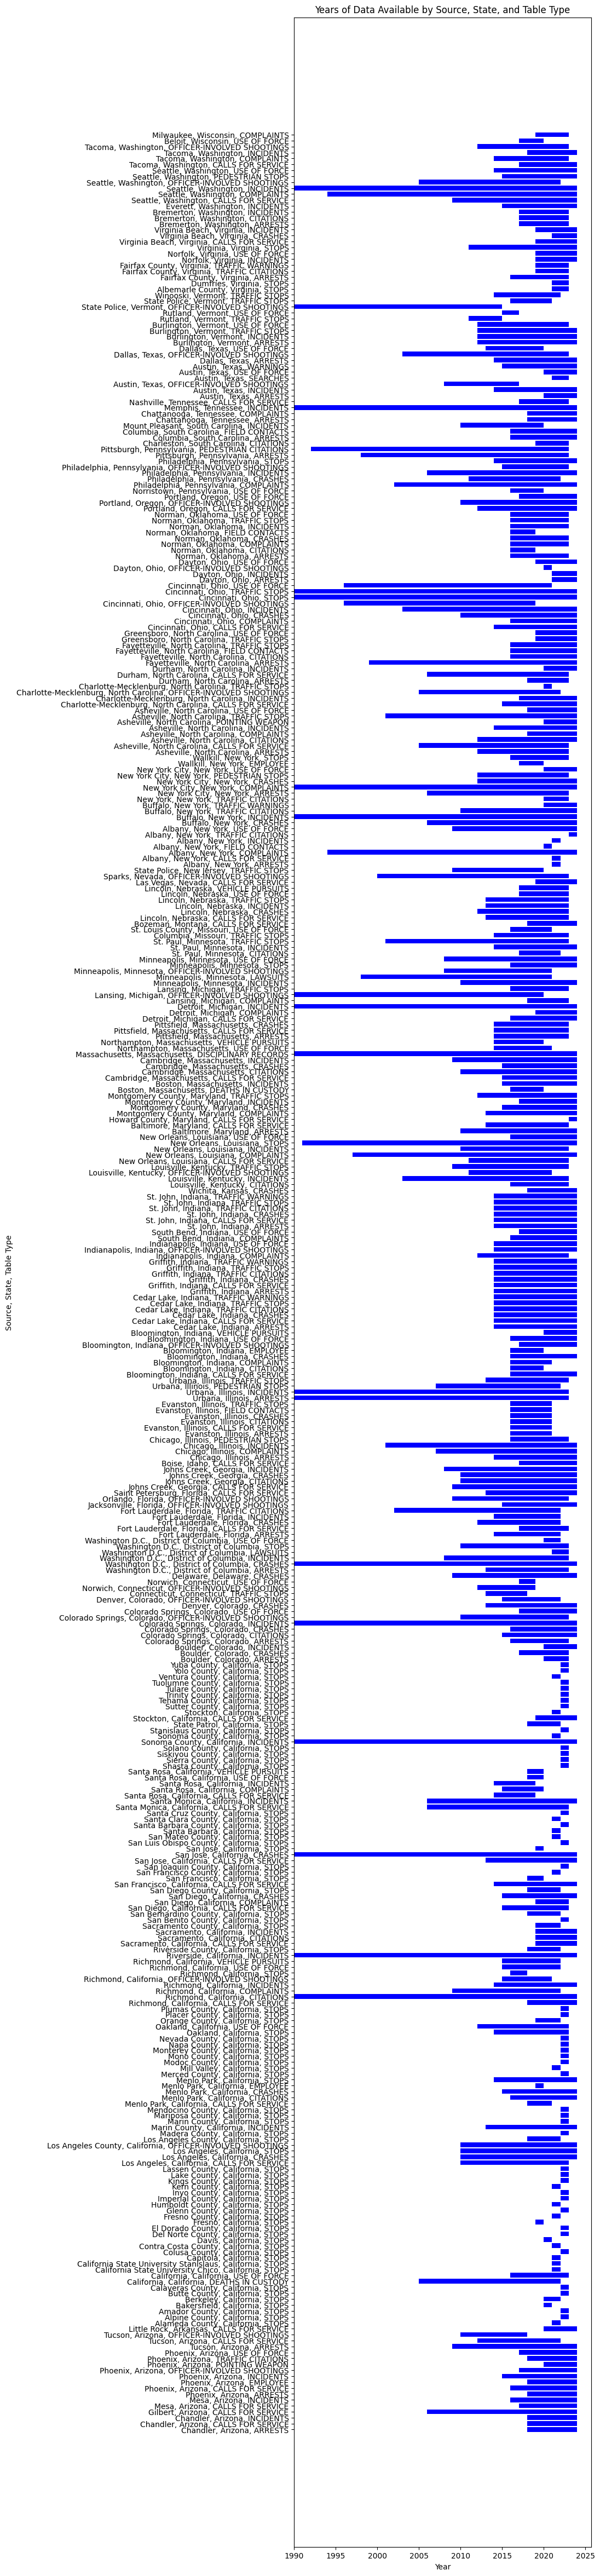

In [26]:
plot_df= df.copy()

# If the MinYear is the same as the MaxYear, then we will add a year to the MaxYear
plot_df['MaxYear'] = plot_df.apply(lambda row: row['MaxYear'] + 1 if row['MinYear'] == row['MaxYear'] else row['MaxYear'], axis=1)

# Plot the data to see the years of data available for each unique combination of 'SourceName', 'State', 'TableType'
plt.figure(figsize=(7, 60))
plt.barh(df['Label'], plot_df['MaxYear'] - plot_df['MinYear'], left=plot_df['MinYear'], color='blue')
plt.xlabel('Year')
plt.ylabel('Source, State, Table Type')
plt.title('Years of Data Available by Source, State, and Table Type')
plt.show()

Table type counts (tabletype_counts >= minimum_tabletype_counts) length is 10. The total number of table types is 23


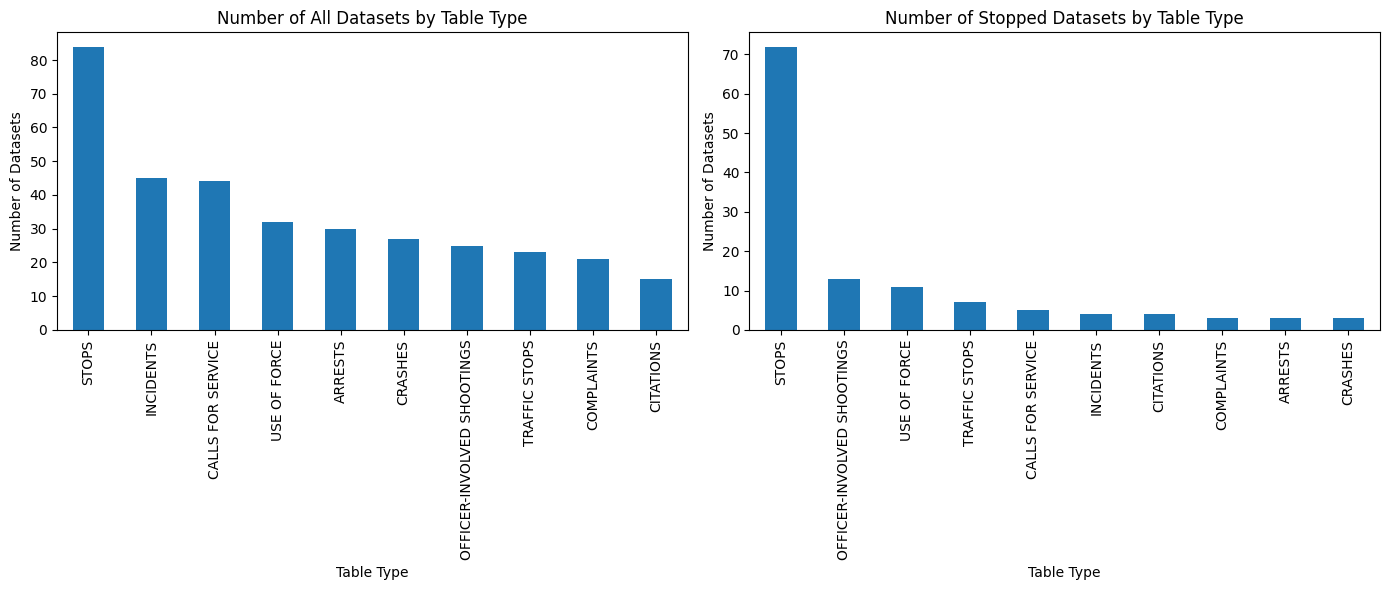

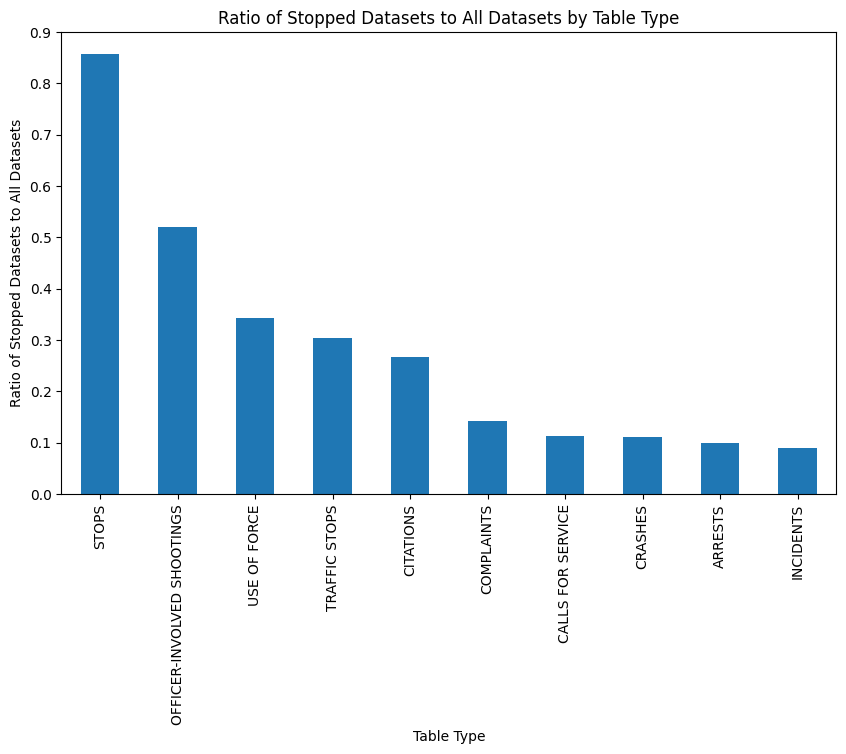

In [28]:
#Find the datasets where the data is most likely to be stopped within the year
current_year = 2024
minimum_tabletype_counts = 10

tabletype_analysis_df = df.copy()
# df['MaxYear'] = df['MaxYear'].fillna(0).astype(int)
tabletype_counts = tabletype_analysis_df['TableType'].value_counts()

# show only statistically significant table types
total_tabletype_counts = len(tabletype_counts)
tabletype_counts = tabletype_counts[tabletype_counts >= minimum_tabletype_counts]
print(f"Table type counts (tabletype_counts >= minimum_tabletype_counts) length is {len(tabletype_counts)}. The total number of table types is {total_tabletype_counts}")

# filter out the table types that are not in the tabletype_counts
tabletype_analysis_df = tabletype_analysis_df[tabletype_analysis_df['TableType'].isin(tabletype_counts.index)]

stopped_datasets = tabletype_analysis_df[tabletype_analysis_df['MaxYear'] < (current_year-1)]
stopped_tabletype_counts = stopped_datasets['TableType'].value_counts()


# compute a bar graph histogram of the number of datasets that are stopped by TableType
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

tabletype_counts.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Table Type')
axes[0].set_ylabel('Number of Datasets')
axes[0].set_title('Number of All Datasets by Table Type')

stopped_tabletype_counts.plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Table Type')
axes[1].set_ylabel('Number of Datasets')
axes[1].set_title('Number of Stopped Datasets by Table Type')

plt.tight_layout()
plt.show()

# Find which type has the highest ratio of stopped datasets
ratio = stopped_tabletype_counts / tabletype_counts
ratio = ratio.fillna(0)

# Create a bar plot of the ratio and sort the values from high to low
ratio = ratio.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ratio.plot(kind='bar')
plt.xlabel('Table Type')
plt.ylabel('Ratio of Stopped Datasets to All Datasets')
plt.title('Ratio of Stopped Datasets to All Datasets by Table Type')
plt.show()